# Notebook to analyse the anomaly detection results from the LSTM model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from alive_progress import alive_bar

from scipy.interpolate import interp1d

# # # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

Num GPUs Available:  1


In [2]:
# Loading the data
TELEM_PATH = r"../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(TELEM_PATH, "telem", )
telem_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2016-02-04 00:00:00.000  2.457422e+06   43.419578  0.314142   287.512192   
1  2016-02-04 00:01:00.000  2.457423e+06   43.419238  0.313883   291.258857   
2  2016-02-04 00:02:00.000  2.457423e+06   43.418972  0.313594   295.003917   
3  2016-02-04 00:03:00.000  2.457423e+06   43.418786  0.313277   298.747190   
4  2016-02-04 00:04:00.000  2.457423e+06   43.418684  0.312933   302.488507   

   theta_T (deg)  black chassis temperature (deg C)  \
0      50.966681                               1.23   
1      54.759942                               1.47   
2      58.556932                               0.00   
3      62.357285                               1.68   
4      66.160507                               3.65   

   silver chassis temperature (deg C)  black panel temperature (deg C)  \
0                               -0.85                            -2.10   
1                                1.17                             2.75   
2                                2.44                             7.00   
3                                1.81                             4.38   
4                                2.77                             6.23   

   silver panel temperature (deg C)  solar panel +X temperature (deg C)  \
0                              2.23                                3.39   
1                              5.04                                0.69   
2                              8.09                               -1.80   
3                              5.67                                2.97   
4                              6.31                                2.14   

   solar panel -X temperature (deg C)  solar panel +Y temperature (deg C)  \
0                               -2.41                               -1.40   
1                                0.92                                2.75   
2                                3.84                               -0.57   
3                                0.50                               -1.40   
4                                0.50                                3.79   

   solar panel -Y temperature (deg C)  
0                                0.43  
1                               -2.91  
2                                1.89  
3                                3.77  
4                                0.22

In [3]:
# Function to section the data into windows
def section_data(df: pd.DataFrame, window_size: int, return_numpy: bool = False, check_continuity: bool = True) -> Union[np.ndarray, pd.DataFrame]:
    columns = np.concatenate((
        ["theta_T"],
        ["black chassis temp " + str(i) for i in range(window_size)],
        ["silver chassis temp " + str(i) for i in range(window_size)],
        ["black panel temp " + str(i) for i in range(window_size)],
        ["silver panel temp " + str(i) for i in range(window_size)],
        ["black chassis temp " + str(window_size)],
        ["silver chassis temp " + str(window_size)],
        ["black panel temp " + str(window_size)],
        ["silver panel temp " + str(window_size)],
    ))

    windowed_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(df) - window_size):
        # Checking if the time difference between the first and the last row is window_size + 1.5 minutes
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        windowed_df.loc[i, "theta_T"] = df.loc[i + window_size, "theta_T (deg)"]
        windowed_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "black chassis temperature (deg C)"]
        windowed_df.iloc[i, window_size + 1:2 * window_size + 1] = df.loc[i:i + window_size - 1, "silver chassis temperature (deg C)"]
        windowed_df.iloc[i, 2 * window_size + 1:3 * window_size + 1] = df.loc[i:i + window_size - 1, "black panel temperature (deg C)"]
        windowed_df.iloc[i, 3 * window_size + 1:4 * window_size + 1] = df.loc[i:i + window_size - 1, "silver panel temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 1] = df.loc[i + window_size, "black chassis temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 2] = df.loc[i + window_size, "silver chassis temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 3] = df.loc[i + window_size, "black panel temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 4] = df.loc[i + window_size, "silver panel temperature (deg C)"]

    windowed_df = windowed_df.dropna().reset_index(drop=True)

    if return_numpy:
        x_array = np.empty(shape=(len(windowed_df), window_size, 4), dtype=np.float64)
        y_array = np.empty(shape=(len(windowed_df), 4), dtype=np.float64)

        for i, row in windowed_df.iterrows():
            x_array[i, :, 0] = row.iloc[1:window_size + 1]
            x_array[i, :, 1] = row.iloc[window_size + 1:2 * window_size + 1]
            x_array[i, :, 2] = row.iloc[2 * window_size + 1:3 * window_size + 1]
            x_array[i, :, 3] = row.iloc[3 * window_size + 1:4 * window_size + 1]

            y_array[i] = row.iloc[4 * window_size + 1:]

        return (windowed_df, x_array, y_array)
    else:
        return windowed_df


def normalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 6:] = (df.iloc[:, 6:] - min_temp) / (max_temp - min_temp)

    return df

In [4]:
# Processing the data to remove constant rows
telem_processed_df = telem_df.copy()
prev_row = telem_processed_df.loc[0]

for i, row in telem_processed_df.iterrows():
    if i == 0:
        continue
    # Check for same temperature values
    if row.loc["black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"].equals(prev_row.loc["black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"]):
        telem_processed_df.drop(i, inplace=True)
        continue
    # Check for same time
    if row.loc["time (utc)"] == prev_row.loc["time (utc)"]:
        telem_processed_df.drop(i, inplace=True)
        continue

    prev_row = row

telem_processed_df = telem_processed_df.reset_index(drop=True)

In [5]:
# Splitting the data into training and testing sets
telem_train_df = telem_processed_df[
    : int(0.8 * len(telem_processed_df))
].copy()
telem_test_df = (
    telem_processed_df[int(0.8 * len(telem_processed_df)) :]
    .copy()
    .reset_index(drop=True)
)

# Normalizing the temperature values:
min_temp = (
    telem_train_df.loc[
        :,
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
    ]
    .min()
    .min()
)
max_temp = (
    telem_train_df.loc[
        :,
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
    ]
    .max()
    .max()
)

telem_train_norm_df = telem_train_df.copy()
telem_test_norm_df = telem_test_df.copy()
telem_train_norm_df.loc[
    :,
    "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
] = (
    telem_train_df.loc[
        :,
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
    ] - min_temp) / (max_temp - min_temp)
telem_test_norm_df.loc[
    :,
    "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
] = (
    telem_test_df.loc[
        :,
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)",
    ] - min_temp) / (max_temp - min_temp)

In [6]:
# Sectioning the data into windows
train_30_df, train_30_x, train_30_y =section_data(telem_train_norm_df, 30, return_numpy=True)
test_30_df, test_30_x, test_30_y = section_data(telem_test_norm_df, 30, return_numpy=True)

train_60_df, train_60_x, train_60_y = section_data(telem_train_norm_df, 60, return_numpy=True)
test_60_df, test_60_x, test_60_y = section_data(telem_test_norm_df, 60, return_numpy=True)

In [7]:
def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 4), output_shape=4):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") == "relu":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation")
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         267264    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

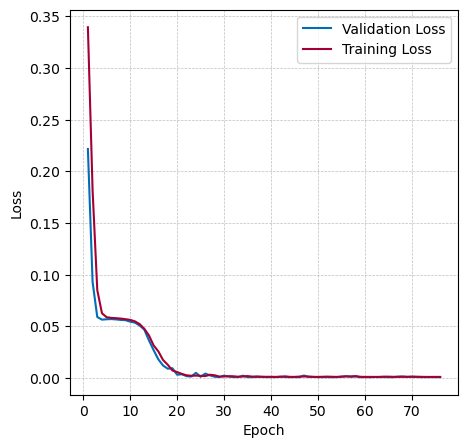

In [8]:
model_30_layers = np.empty(shape=(7), dtype=dict,)
model_30_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_30_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_30_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_30_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_30_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_30_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_30_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_30, recommended_device = create_model(
    model_30_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)
# model_30.set_weights(initial_weights)

model_30.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)

with tf.device(recommended_device):
    history_30 = model_30.fit(
            train_30_x,
            train_30_y,
            epochs=200,
            validation_data=(test_30_x, test_30_y),
            callbacks=[early_stopping],
        )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_30.history["loss"]), len(history_30.history["loss"])),
    history_30.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_30.history["loss"]), len(history_30.history["loss"])),
    history_30.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [9]:
model_60_layers = np.empty(shape=(7), dtype=dict,)
model_60_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_60_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_60_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_60, recommended_device = create_model(
    model_60_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)
# model_60.set_weights(initial_weights)

model_60.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)

with tf.device(recommended_device):
    history_60 = model_60.fit(
            train_60_x,
            train_60_y,
            epochs=200,
            validation_data=(test_60_x, test_60_y),
            callbacks=[early_stopping],
        )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, None, 256)         267264    
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_9 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_11 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_12 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_13 (LSTM)              (None, 16)               

In [ ]:
# Saving the models:
MODEL_30_SAVE_PATH = r"./30_step_gpu_lstm.h5"
MODEL_60_SAVE_PATH = r"./60_step_gpu_lstm.h5"

model_30.save(MODEL_30_SAVE_PATH, save_format="h5")
model_60.save(MODEL_60_SAVE_PATH, save_format="h5")

In [ ]:
# Loading the models:
MODEL_30_SAVE_PATH = r"./funcube-1-analysis/30_step_lstm.h5"
MODEL_60_SAVE_PATH = r"./funcube-1-analysis/60_step_lstm.h5"

model_30 = tf.keras.models.load_model(MODEL_30_SAVE_PATH)
model_60 = tf.keras.models.load_model(MODEL_60_SAVE_PATH)

In [10]:
def plot_model(theta_T_vals, y_data, y_single_pred=None, y_auto_pred=None, plt_title=None, limit_axis=True, save_plot=False, save_path=None):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(
        theta_T_vals,
        y_data[:, 0],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 0],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 0],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black chassis")

    plt.subplot(2, 2, 2)
    plt.plot(
        theta_T_vals,
        y_data[:, 1],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 1],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 1],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver chassis")

    plt.subplot(2, 2, 3)
    plt.plot(
        theta_T_vals,
        y_data[:, 2],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 2],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 2],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black panel")

    plt.subplot(2, 2, 4)
    plt.plot(
        theta_T_vals,
        y_data[:, 3],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 3],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 3],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver panel")

    if plt_title is not None:
        plt.suptitle(plt_title)
    plt.show()

    if save_plot:
        plt.savefig(save_path)
    
    plt.close()

In [11]:
def test_model(model, x_data, single_step_pred=False, auto_regressive_pred=False):
    if single_step_pred:
        y_single_pred = model.predict(x_data, verbose=False)
    else:
        y_single_pred = None

    if auto_regressive_pred:
        x_auto_pred = np.empty(shape=x_data.shape, dtype=np.float64)
        y_auto_pred = np.empty(shape=(x_data.shape[0], 4), dtype=np.float64)

        x_auto_pred[0] = x_data[0]
        with alive_bar(total=x_data.shape[0], theme="classic", force_tty=True, title="Predicting") as bar:
            for i, x in enumerate(x_auto_pred):
                y_auto_pred[i] = model.predict(x.reshape(1, x_auto_pred.shape[1], x_auto_pred.shape[2]), verbose=False)
                if i < x_data.shape[0]-1:
                    x_auto_pred[i+1] = np.concatenate((x[1:], y_auto_pred[i].reshape(1, 4)), axis=0)
                bar()
    else:
        y_auto_pred = None

    return y_single_pred, y_auto_pred

In [13]:
def create_artificial_anomaly(window_size, anomaly_black_chassis=False, anomaly_silver_chassis=False, anomaly_black_panel=False, anomaly_silver_panel=False):
    artificial_anomaly_df = pd.DataFrame(
        columns=[
            "theta_T (deg)",
            "black chassis temperature (deg C)",
            "silver chassis temperature (deg C)",
            "black panel temperature (deg C)",
            "silver panel temperature (deg C)",
        ],
    )
    orbit_0_end = 94
    orbit_0_start = orbit_0_end - window_size
    orbit_1_start = 94
    orbit_1_end = 191
    anomaly_df_temp_0 = anomaly_df[60-window_size:59].copy().reset_index(drop=True)
    anomaly_df_temp_1 = anomaly_df[60:].copy().reset_index(drop=True)
    
    artificial_anomaly_df["theta_T (deg)"] = telem_test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end]
    # One orbit before anomaly:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            telem_test_norm_df["black chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )
    
    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            telem_test_norm_df["silver chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            telem_test_norm_df["black panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            telem_test_norm_df["silver panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )


    artificial_anomaly_df["black chassis temperature (deg C)"] = black_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver chassis temperature (deg C)"] = silver_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["black panel temperature (deg C)"] = black_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver panel temperature (deg C)"] = silver_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )

    # Anomaly orbit:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            telem_test_norm_df["black chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            telem_test_norm_df["silver chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            telem_test_norm_df["black panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            telem_test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            telem_test_norm_df["silver panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    artificial_anomaly_df = artificial_anomaly_df.reset_index(drop=True)

    theta_T_anomaly_orbit = telem_test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end].to_numpy()
    for i in range(len(theta_T_anomaly_orbit)):
        artificial_anomaly_df.loc[window_size + i, "theta_T (deg)"] = theta_T_anomaly_orbit[i]
        artificial_anomaly_df.loc[window_size + i, "black chassis temperature (deg C)"] = black_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver chassis temperature (deg C)"] = silver_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "black panel temperature (deg C)"] = black_panel_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver panel temperature (deg C)"] = silver_panel_interp(
            theta_T_anomaly_orbit[i]
        )   

    return artificial_anomaly_df

In [12]:
# Orbit with known anomaly:
anomaly_df = telem_df.loc[414:571].copy().reset_index(drop=True)

# Normalizing data:
anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (
    anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp
) / (max_temp - min_temp)


Predicting [========================================] 97/97 [100%] in 6.9s (14.01/s)                                    
Predicting [========================================] 97/97 [100%] in 6.2s (15.60/s)                                    


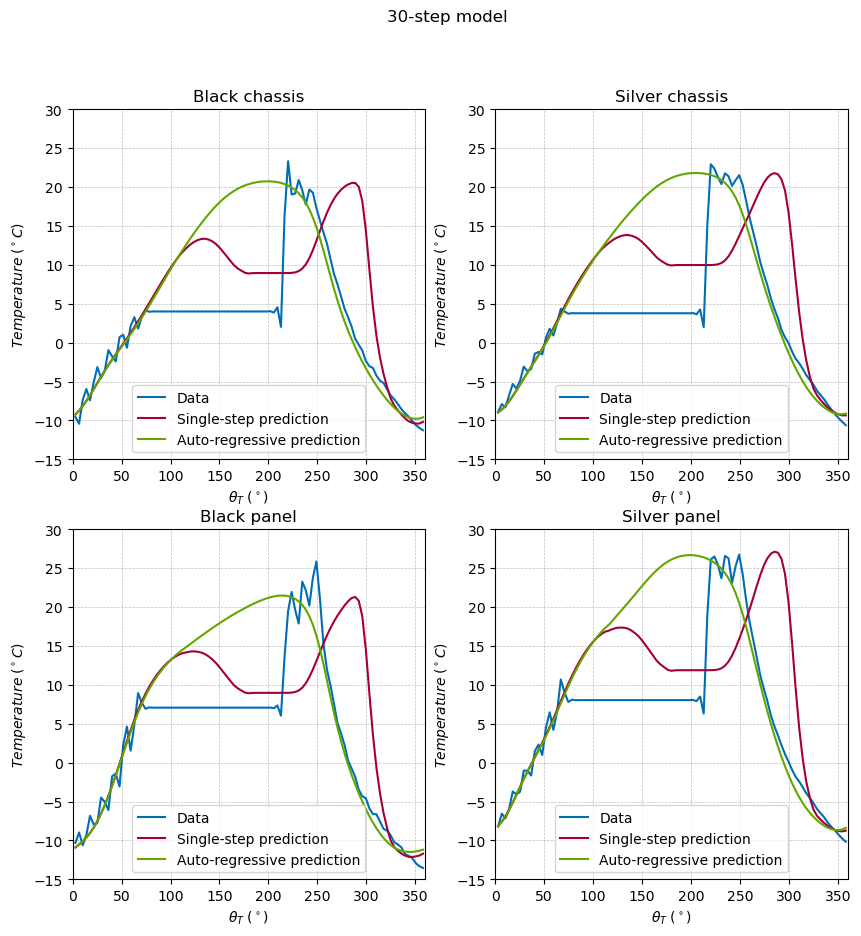

In [41]:
# Orbit without anomaly:
base_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True)
base_60_df = create_artificial_anomaly(window_size=60)

base_30_window_df, base_30_x, base_30_y = section_data(base_30_df, window_size=30, return_numpy=True, check_continuity=False)
base_60_window_df, base_60_x, base_60_y = section_data(base_60_df, window_size=60, return_numpy=True, check_continuity=False)

base_30_y_single_pred, base_30_y_auto_pred = test_model(model_30, base_30_x, single_step_pred=True, auto_regressive_pred=True)
base_60_y_single_pred, base_60_y_auto_pred = test_model(model_60, base_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    base_30_window_df["theta_T"],
    base_30_y * (max_temp - min_temp) + min_temp,
    base_30_y_single_pred * (max_temp - min_temp) + min_temp,
    base_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model",
)


In [ ]:
print(len())

In [42]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(
    base_30_window_df["theta_T"].values,
    base_30_y[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.xlim(0, 360)
plt.ylim(-15, 32)
plt.title("Black chassis temperature")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    base_30_window_df["theta_T"].values,
    base_30_y[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
)

plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.xlim(0, 360)
plt.ylim(-15, 32)
plt.title("Silver chassis temperature")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(
    base_30_window_df["theta_T"].values,
    base_30_y[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.xlim(0, 360)
plt.ylim(-15, 32)
plt.title("Black panel temperature")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    base_30_window_df["theta_T"].values,
    base_30_y[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.xlim(0, 360)
plt.ylim(-15, 32)
plt.title("Silver panel temperature")
plt.grid()


plt.show()

In [15]:

plot_model(
    base_60_window_df["theta_T"],
    base_60_y * (max_temp - min_temp) + min_temp,
    base_60_y_single_pred * (max_temp - min_temp) + min_temp,
    base_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60 temperature step model;\nNo anomaly",
)

Predicting [========================================] 97/97 [100%] in 5.7s (17.16/s)                                    
Predicting [========================================] 97/97 [100%] in 6.3s (15.44/s)                                    


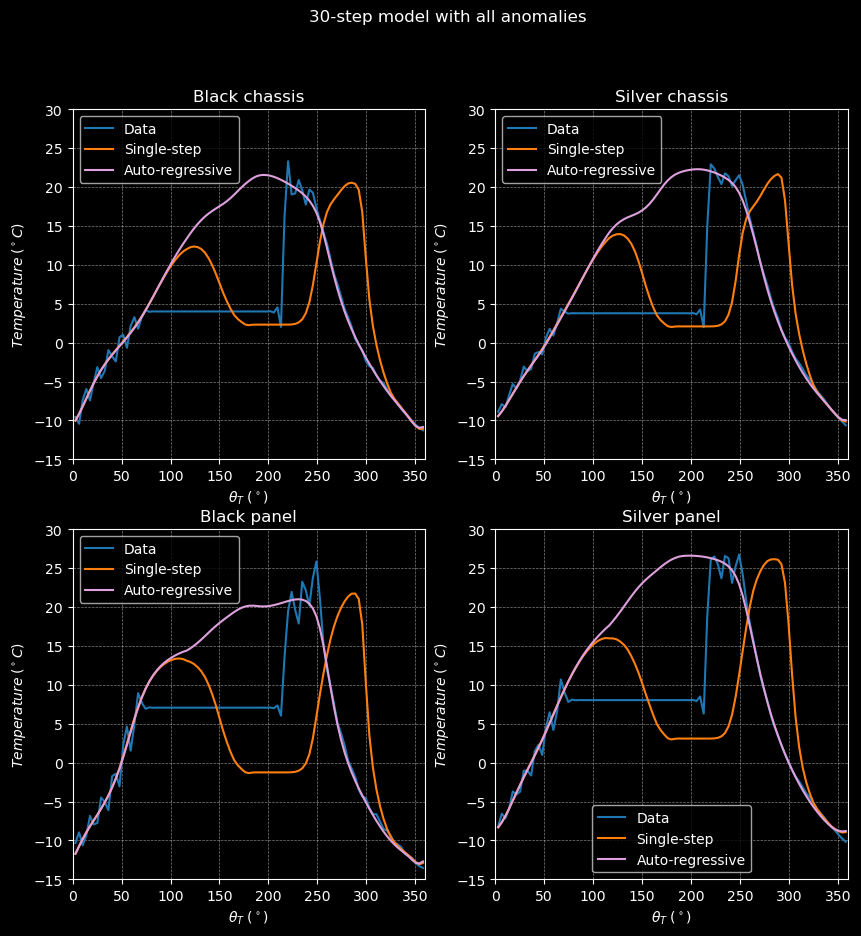

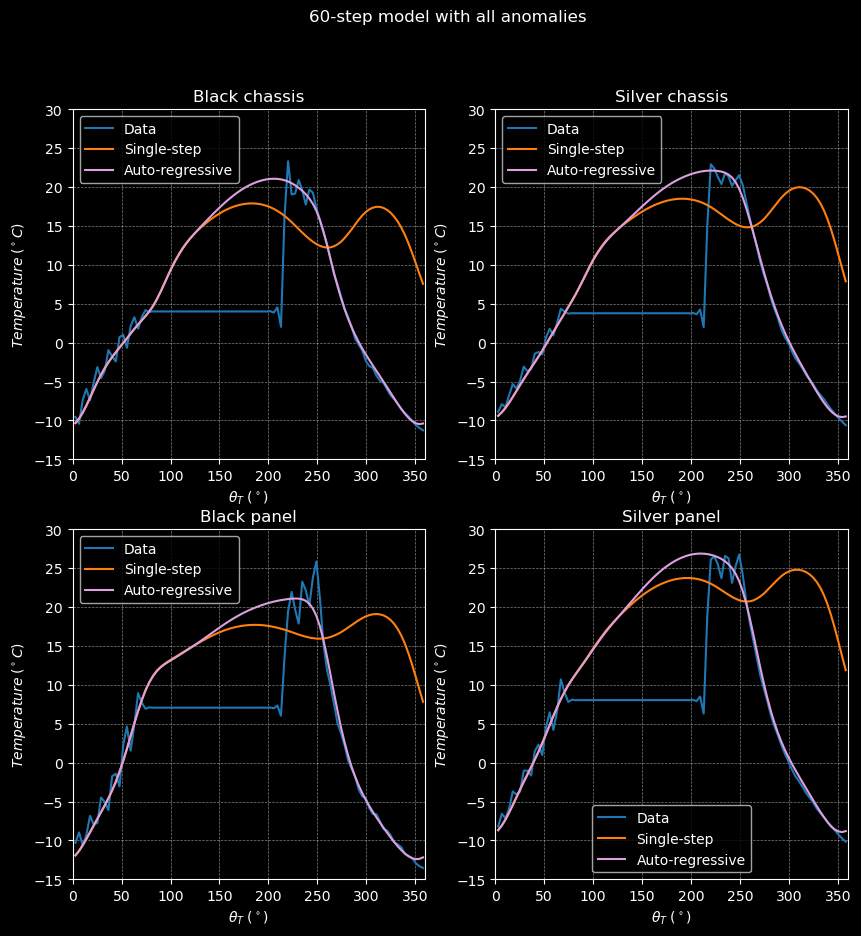

In [ ]:
# Actual orbit with anomaly:
all_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True)
all_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True)

all_anomaly_30_window_df, all_anomaly_30_x, all_anomaly_30_y = section_data(all_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
all_anomaly_60_window_df, all_anomaly_60_x, all_anomaly_60_y = section_data(all_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

all_anomaly_30_y_single_pred, all_anomaly_30_y_auto_pred = test_model(model_30, all_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
all_anomaly_60_y_single_pred, all_60_y_auto_pred = test_model(model_60, all_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    all_anomaly_30_window_df["theta_T"],
    all_anomaly_30_y * (max_temp - min_temp) + min_temp,
    all_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    all_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model with all anomalies",
)

plot_model(
    all_anomaly_60_window_df["theta_T"],
    all_anomaly_60_y * (max_temp - min_temp) + min_temp,
    all_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    all_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model with all anomalies",
)

Predicting [========================================] 97/97 [100%] in 6.3s (15.50/s)                                    
Predicting [========================================] 97/97 [100%] in 6.3s (15.35/s)                                    


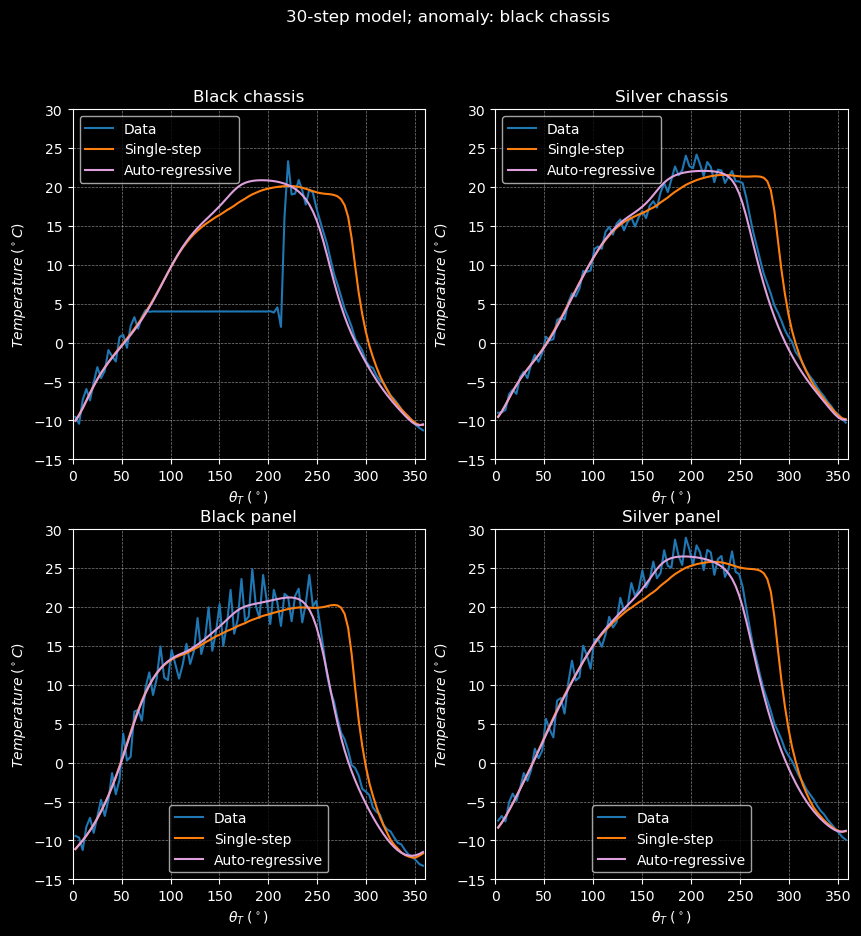

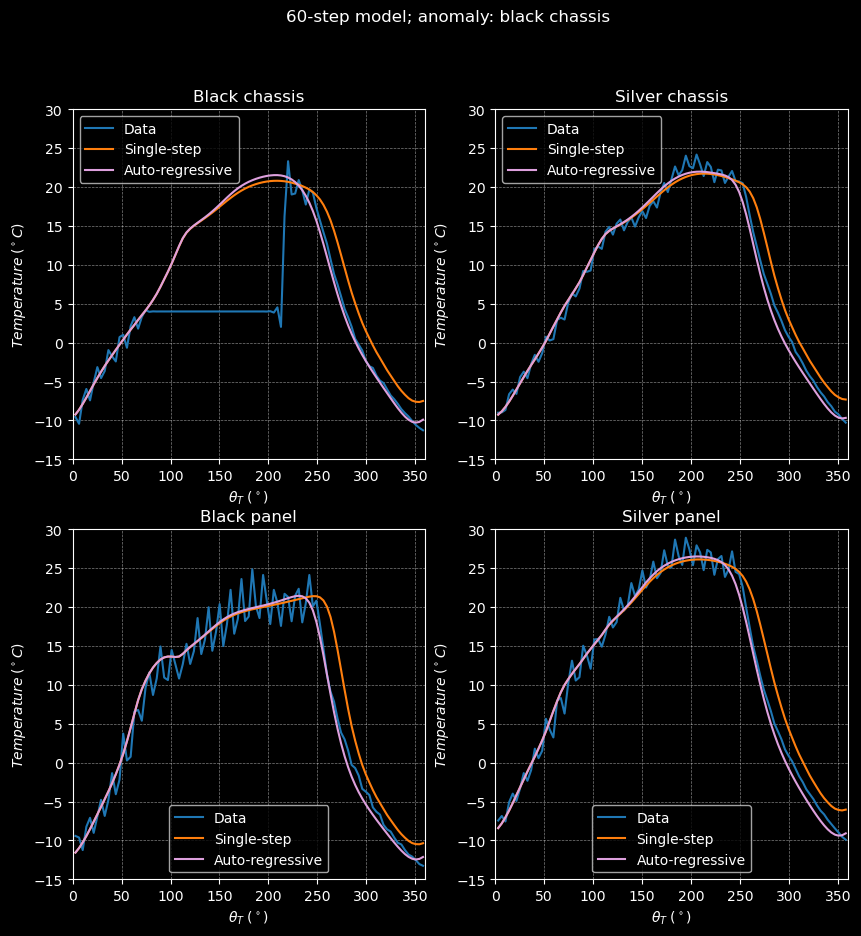

In [16]:
# Artificial anomaly orbit: black chassis
one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True,)

one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
one_anomaly_60_y_single_pred, one_60_y_auto_pred = test_model(model_60, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    one_anomaly_30_window_df["theta_T"],
    one_anomaly_30_y * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black chassis",
)

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: black chassis",
)

Predicting [========================================] 97/97 [100%] in 5.9s (16.30/s)                                    
Predicting [========================================] 97/97 [100%] in 6.6s (14.68/s)                                    


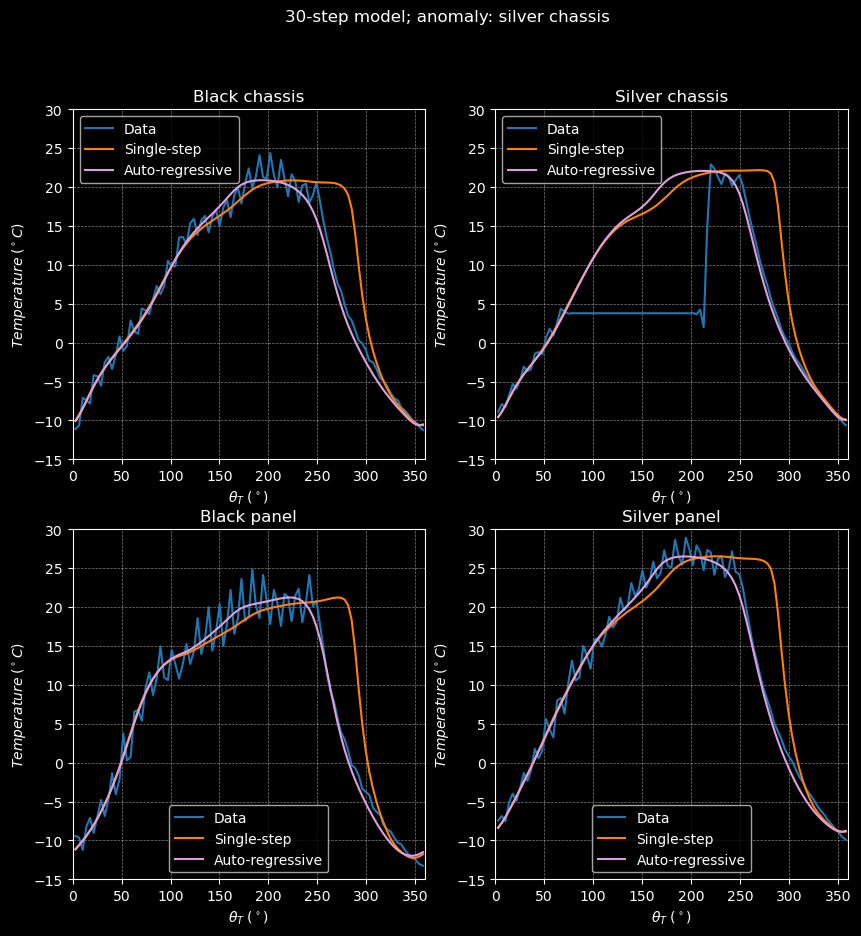

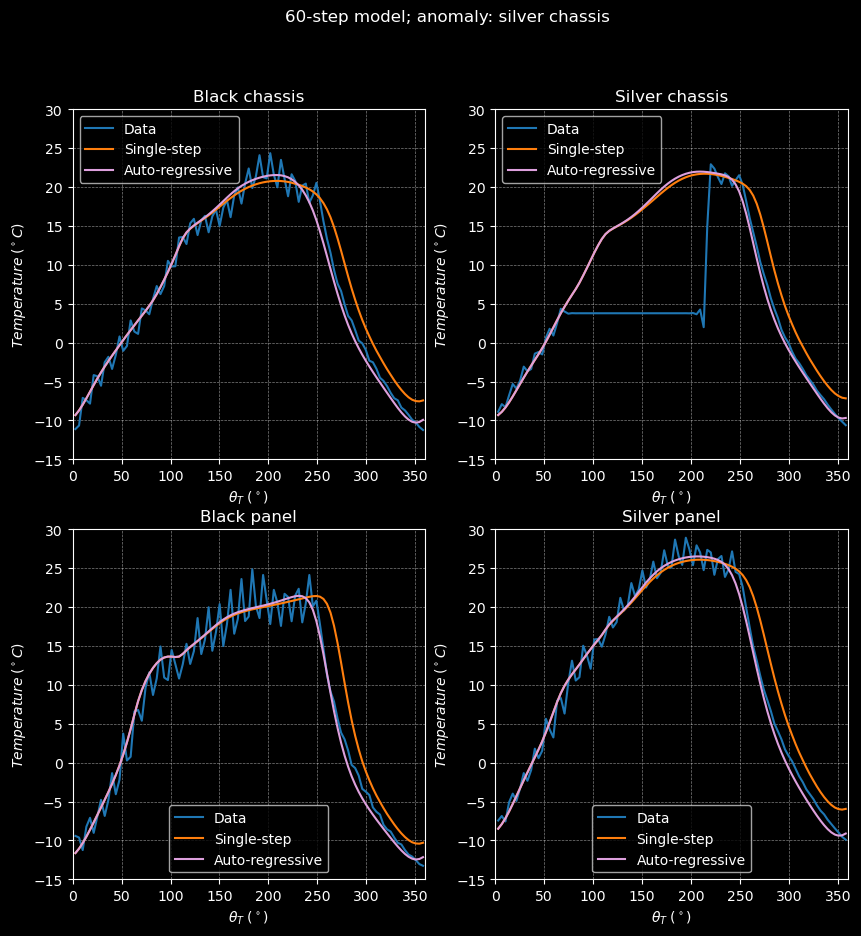

In [17]:
# Artificial anomaly orbit: silver chassis
one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_silver_chassis=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_silver_chassis=True,)

one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
one_anomaly_60_y_single_pred, one_60_y_auto_pred = test_model(model_60, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    one_anomaly_30_window_df["theta_T"],
    one_anomaly_30_y * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: silver chassis",
)

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: silver chassis",
)

Predicting [========================================] 97/97 [100%] in 5.7s (16.93/s)                                    
Predicting [========================================] 97/97 [100%] in 6.3s (15.41/s)                                    


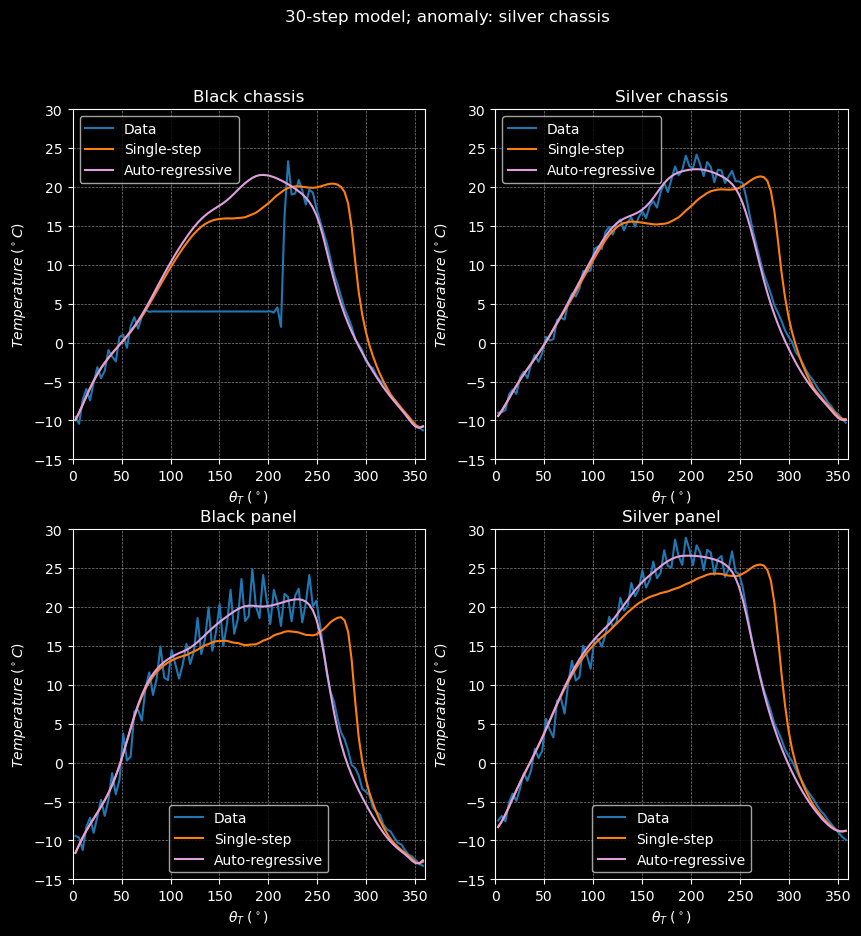

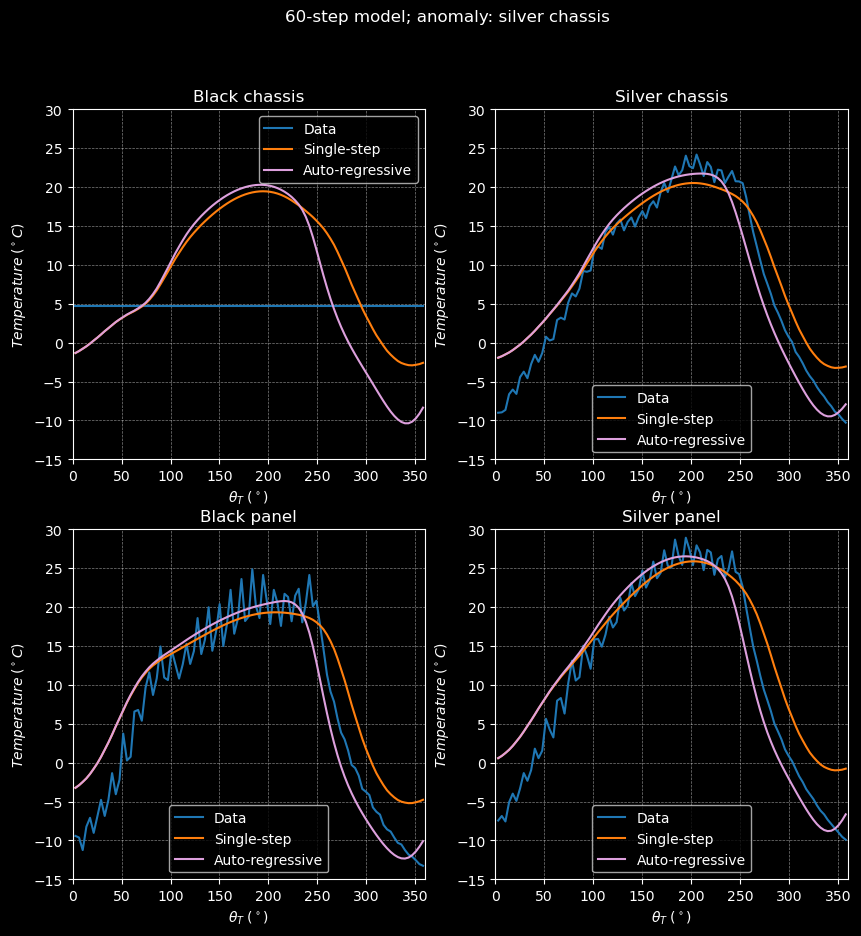

In [ ]:
# Artificial anomaly orbit: silver chassis
one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True,)

one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

one_anomaly_60_x[:, :, 0] = 0.5
one_anomaly_60_y[:, 0] = 0.5


one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
one_anomaly_60_y_single_pred, one_60_y_auto_pred = test_model(model_60, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    one_anomaly_30_window_df["theta_T"],
    one_anomaly_30_y * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: silver chassis",
)

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: silver chassis",
)

Predicting [========================================] 97/97 [100%] in 5.7s (17.14/s)                                    
Predicting [========================================] 97/97 [100%] in 6.7s (14.53/s)                                    


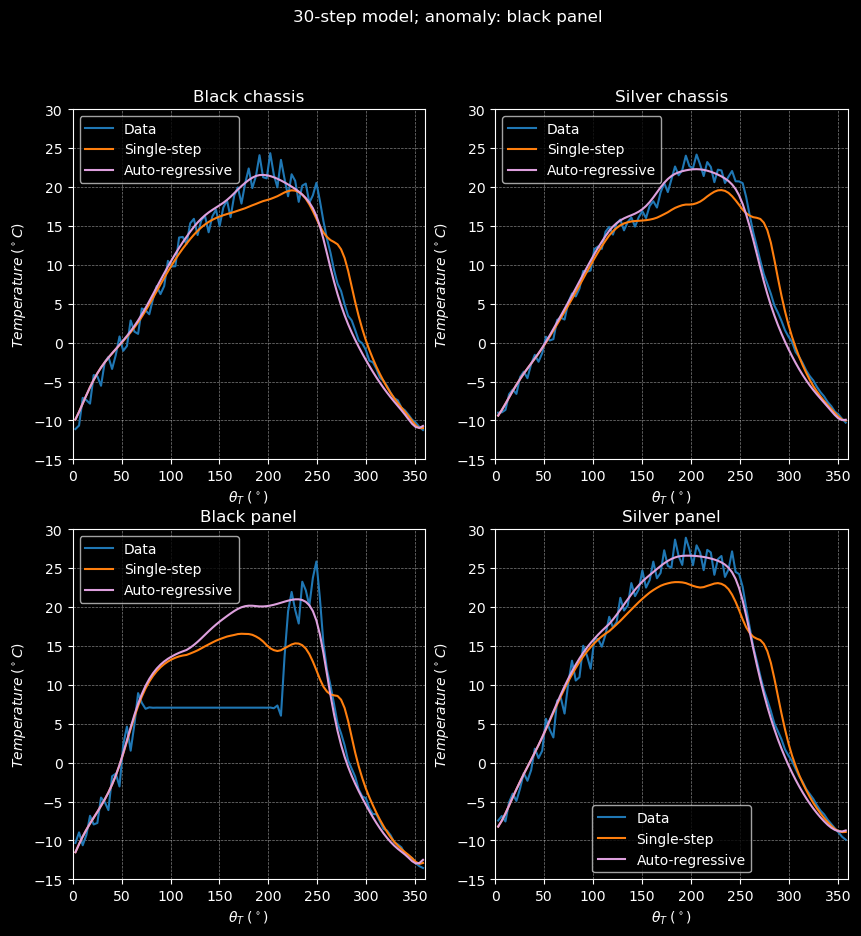

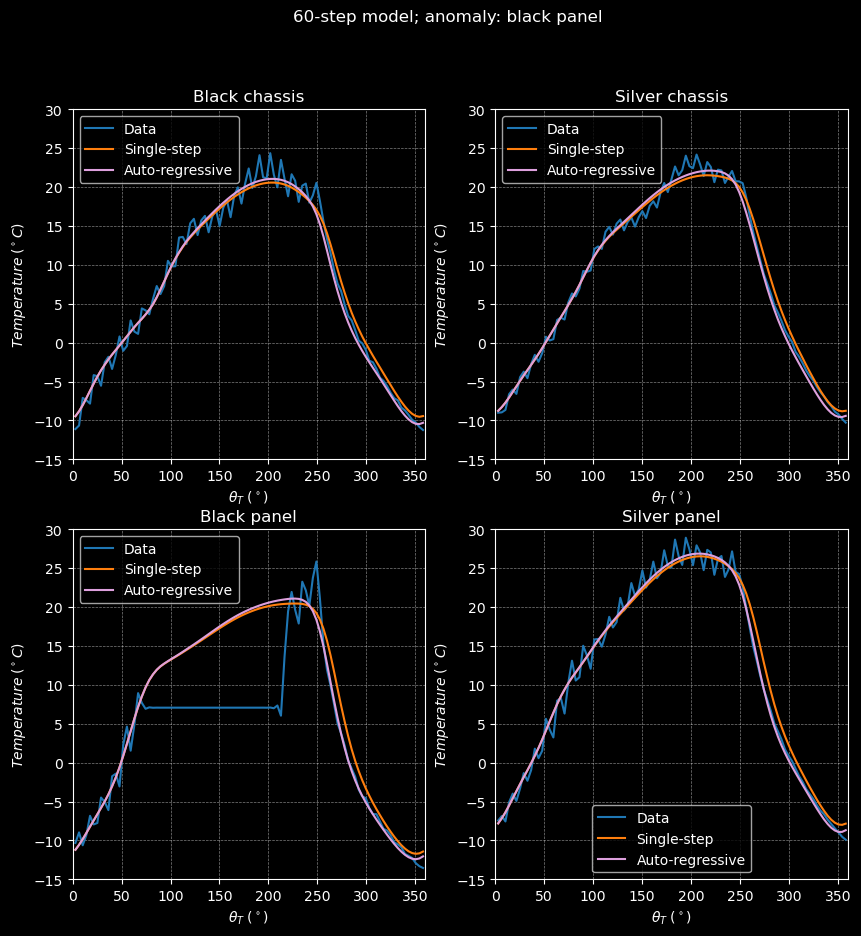

In [ ]:
# Artificial anomaly orbit: black panel
one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_panel=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_panel=True,)

one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
one_anomaly_60_y_single_pred, one_60_y_auto_pred = test_model(model_60, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    one_anomaly_30_window_df["theta_T"],
    one_anomaly_30_y * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black panel",
)

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: black panel",
)

Predicting [========================================] 97/97 [100%] in 5.8s (16.74/s)                                    
Predicting [========================================] 97/97 [100%] in 6.2s (15.54/s)                                    


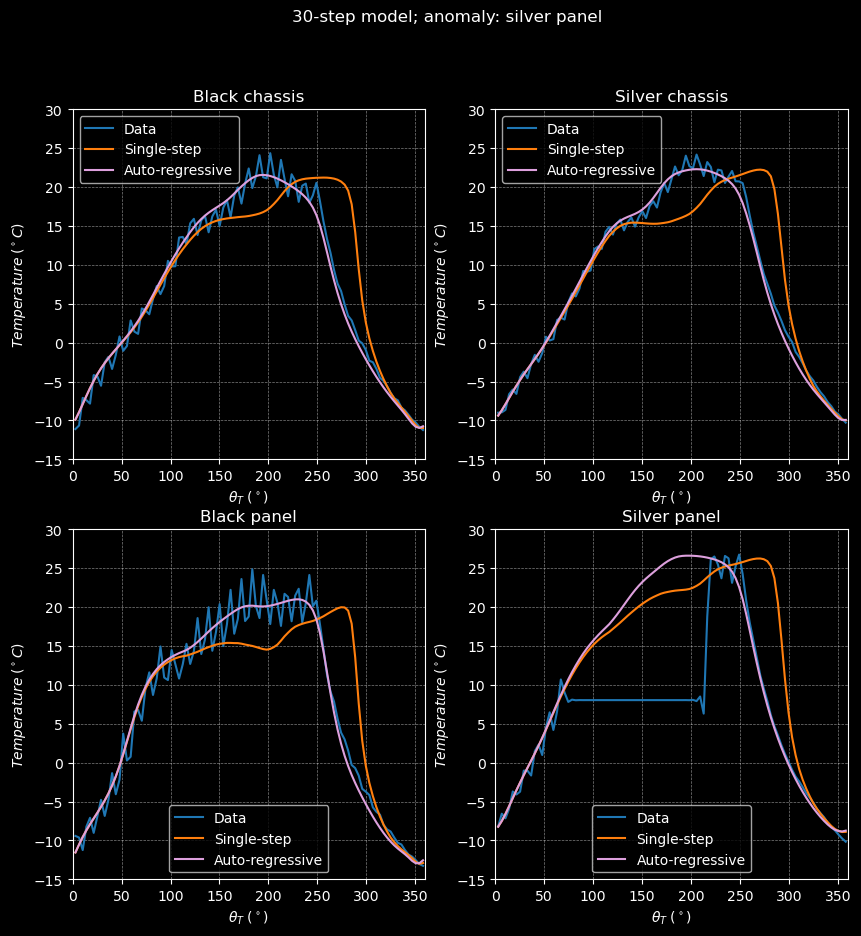

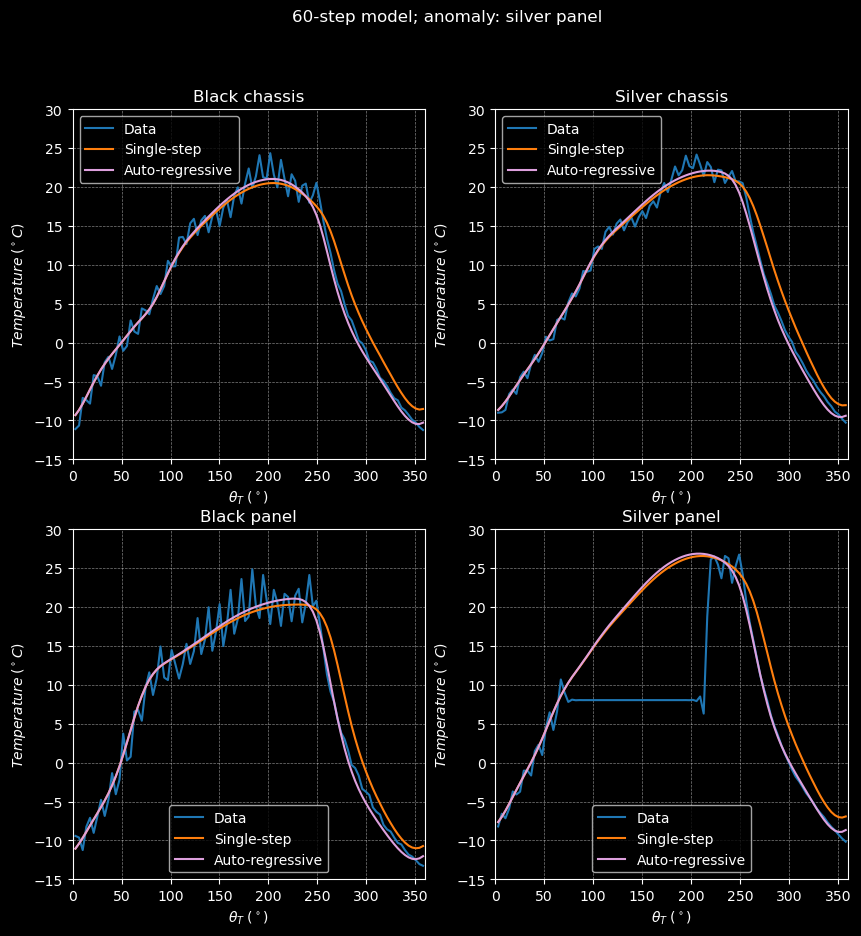

In [ ]:
# Artificial anomaly orbit: silver panel
one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_silver_panel=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_silver_panel=True,)

one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
one_anomaly_60_y_single_pred, one_60_y_auto_pred = test_model(model_60, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    one_anomaly_30_window_df["theta_T"],
    one_anomaly_30_y * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: silver panel",
)

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: silver panel",
)

Predicting [========================================] 97/97 [100%] in 5.7s (17.14/s)                                    
Predicting [========================================] 97/97 [100%] in 6.4s (15.14/s)                                    


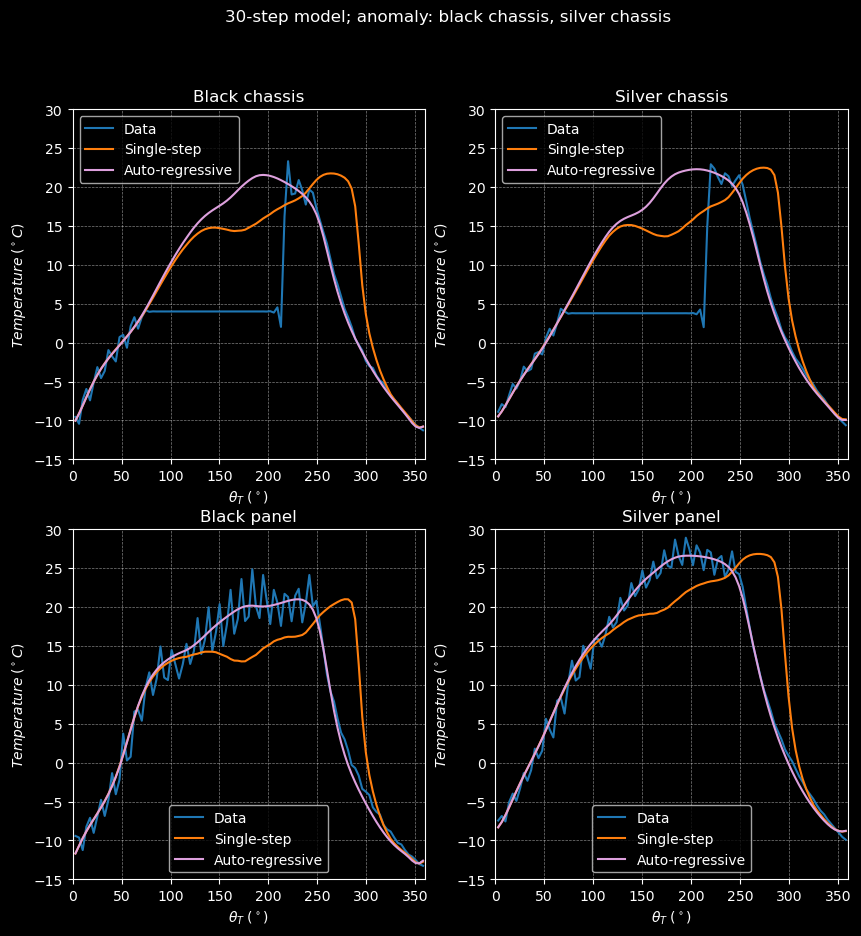

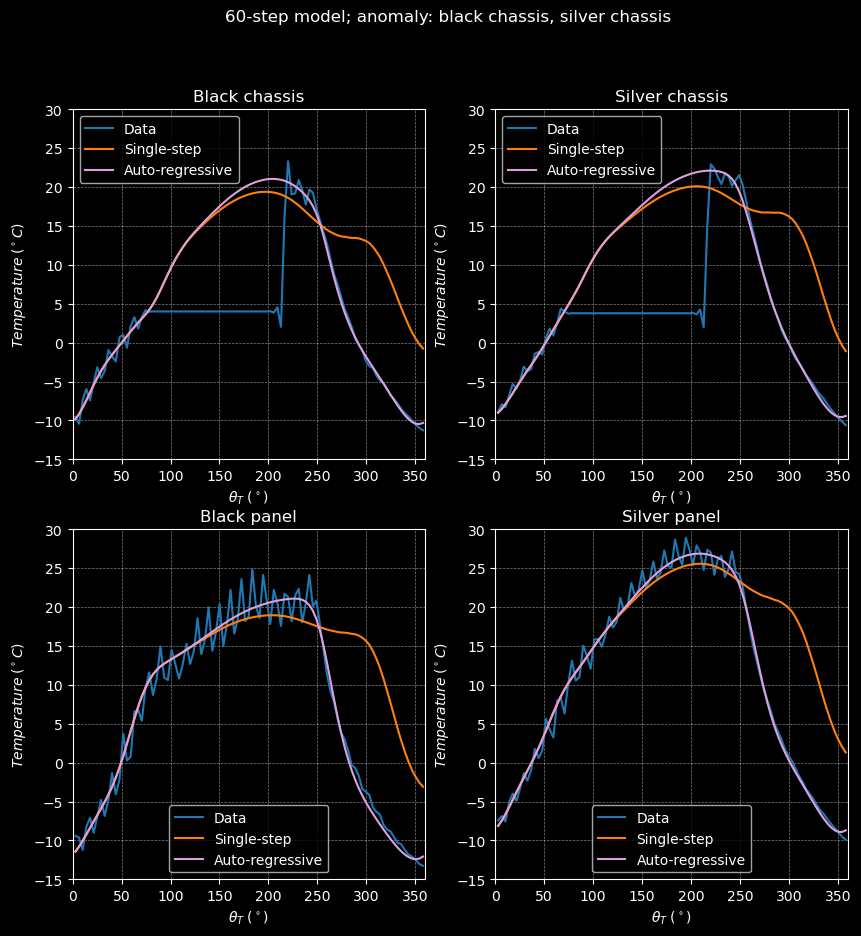

In [ ]:
# Artificial anomaly orbit: black chassis, silver chassis
two_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_silver_chassis=True,)
two_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_chassis=True,)

two_anomaly_30_window_df, two_anomaly_30_x, two_anomaly_30_y = section_data(two_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
two_anomaly_60_window_df, two_anomaly_60_x, two_anomaly_60_y = section_data(two_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

two_anomaly_30_y_single_pred, two_anomaly_30_y_auto_pred = test_model(model_30, two_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
two_anomaly_60_y_single_pred, two_60_y_auto_pred = test_model(model_60, two_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    two_anomaly_30_window_df["theta_T"],
    two_anomaly_30_y * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black chassis, silver chassis",
)

plot_model(
    two_anomaly_60_window_df["theta_T"],
    two_anomaly_60_y * (max_temp - min_temp) + min_temp,
    two_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    two_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: black chassis, silver chassis",
)

Predicting [========================================] 97/97 [100%] in 6.0s (16.15/s)                                    
Predicting [========================================] 97/97 [100%] in 6.4s (15.23/s)                                    


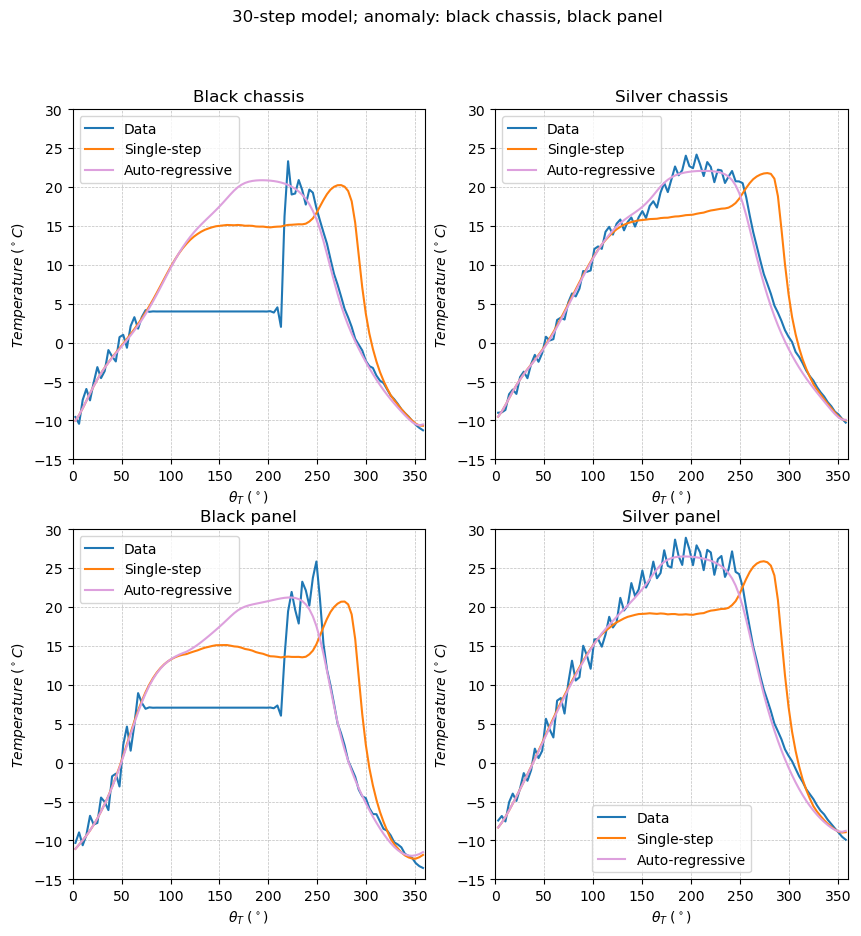

In [23]:
# Artificial anomaly orbit: black chassis, black panel
two_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_black_panel=True,)
two_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_black_panel=True,)

two_anomaly_30_window_df, two_anomaly_30_x, two_anomaly_30_y = section_data(two_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
two_anomaly_60_window_df, two_anomaly_60_x, two_anomaly_60_y = section_data(two_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

two_anomaly_30_y_single_pred, two_anomaly_30_y_auto_pred = test_model(model_30, two_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
two_anomaly_60_y_single_pred, two_60_y_auto_pred = test_model(model_60, two_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    two_anomaly_30_window_df["theta_T"],
    two_anomaly_30_y * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black chassis, black panel",
)


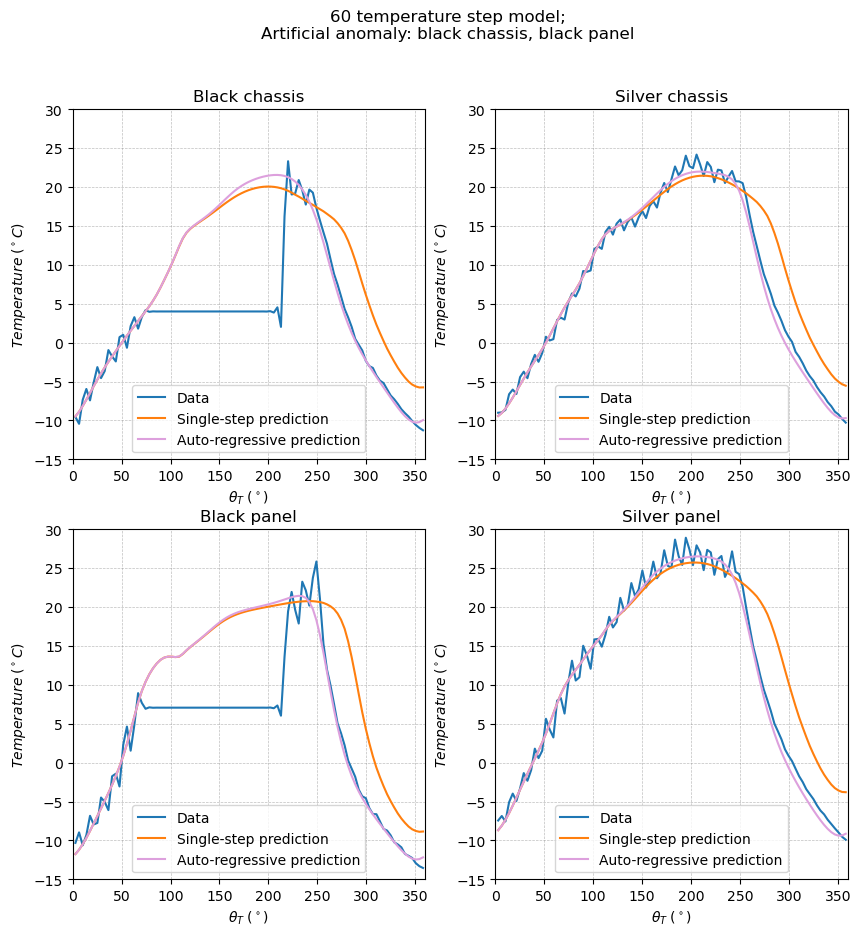

In [28]:

plot_model(
    two_anomaly_60_window_df["theta_T"],
    two_anomaly_60_y * (max_temp - min_temp) + min_temp,
    two_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    two_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60 temperature step model;\nArtificial anomaly: black chassis, black panel",
)

Predicting [========================================] 97/97 [100%] in 5.7s (16.91/s)                                    
Predicting [========================================] 97/97 [100%] in 6.2s (15.74/s)                                    


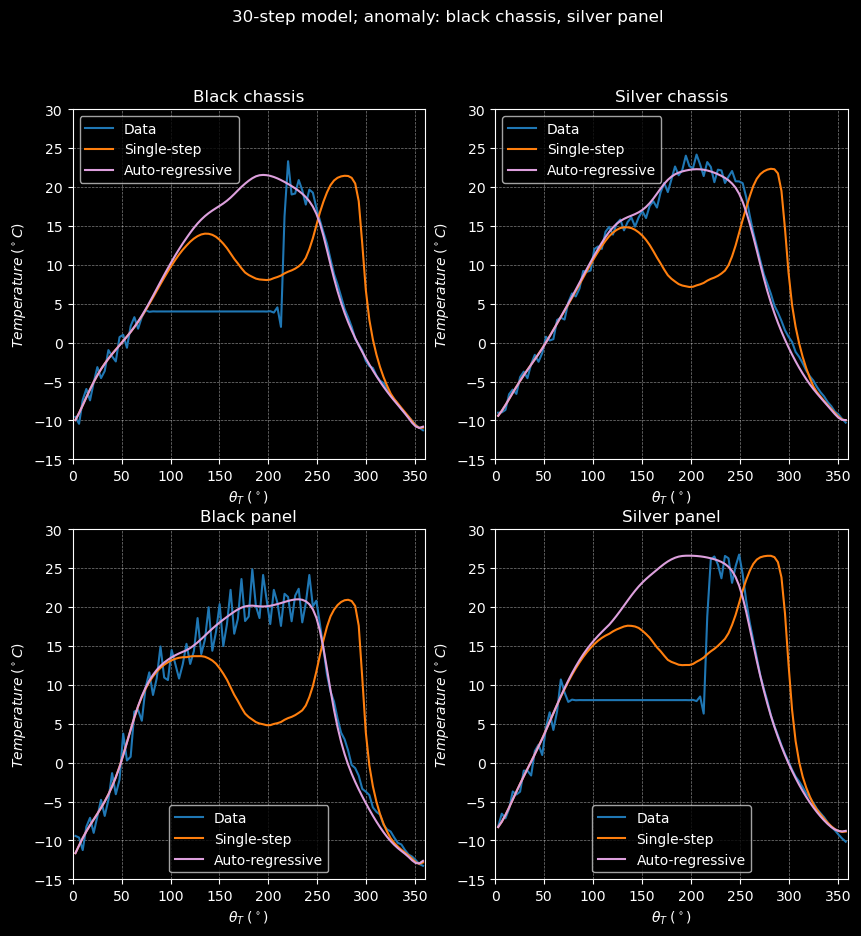

In [ ]:
# Artificial anomaly orbit: black chassis, silver panel
two_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_silver_panel=True,)
two_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_panel=True,)

two_anomaly_30_window_df, two_anomaly_30_x, two_anomaly_30_y = section_data(two_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
two_anomaly_60_window_df, two_anomaly_60_x, two_anomaly_60_y = section_data(two_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

two_anomaly_30_y_single_pred, two_anomaly_30_y_auto_pred = test_model(model_30, two_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
two_anomaly_60_y_single_pred, two_60_y_auto_pred = test_model(model_60, two_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    two_anomaly_30_window_df["theta_T"],
    two_anomaly_30_y * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    two_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black chassis, silver panel",
)

plot_model(
    two_anomaly_60_window_df["theta_T"],
    two_anomaly_60_y * (max_temp - min_temp) + min_temp,
    two_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    two_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: black chassis, silver panel",
)

Predicting [========================================] 97/97 [100%] in 5.6s (17.33/s)                                    
Predicting [========================================] 97/97 [100%] in 5.9s (16.47/s)                                    


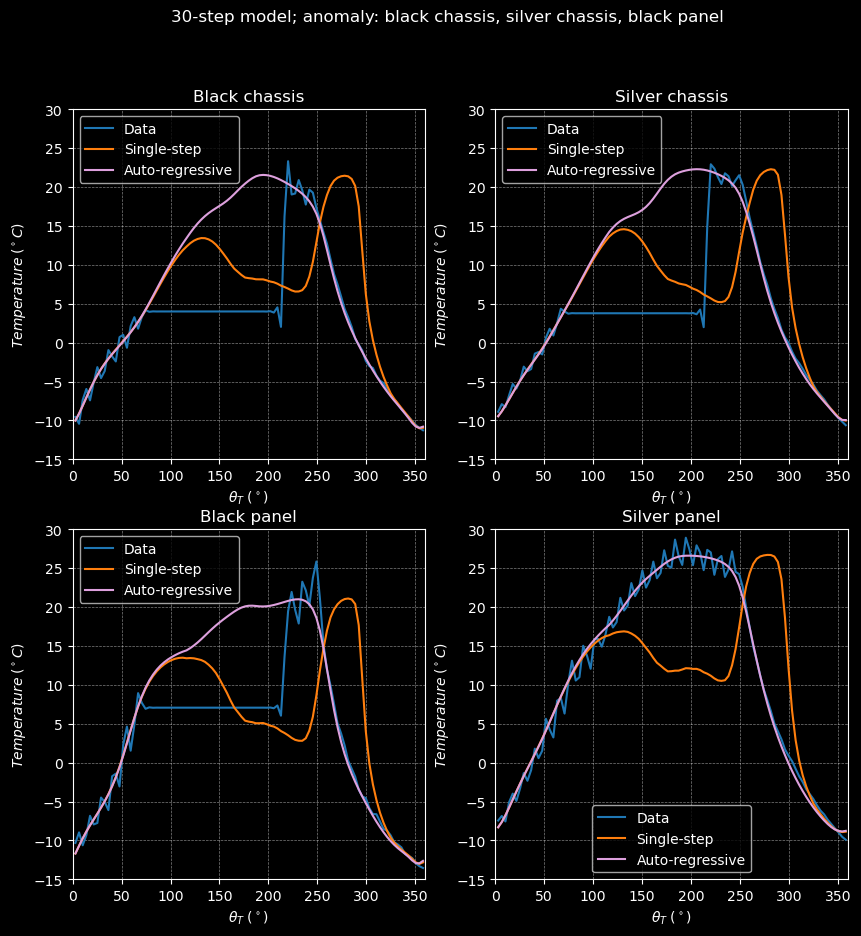

In [ ]:
# Artificial anomaly orbit: black chassis, silver chassis, black panel
three_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True,)
three_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True,)

three_anomaly_30_window_df, three_anomaly_30_x, three_anomaly_30_y = section_data(three_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
three_anomaly_60_window_df, three_anomaly_60_x, three_anomaly_60_y = section_data(three_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

three_anomaly_30_y_single_pred, three_anomaly_30_y_auto_pred = test_model(model_30, three_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
three_anomaly_60_y_single_pred, three_60_y_auto_pred = test_model(model_60, three_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    three_anomaly_30_window_df["theta_T"],
    three_anomaly_30_y * (max_temp - min_temp) + min_temp,
    three_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    three_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: black chassis, silver chassis, black panel",
)

plot_model(
    three_anomaly_60_window_df["theta_T"],
    three_anomaly_60_y * (max_temp - min_temp) + min_temp,
    three_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    three_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: black chassis, silver chassis, black panel",
)

Predicting [========================================] 97/97 [100%] in 5.9s (16.52/s)                                    
Predicting [========================================] 97/97 [100%] in 6.1s (15.98/s)                                    


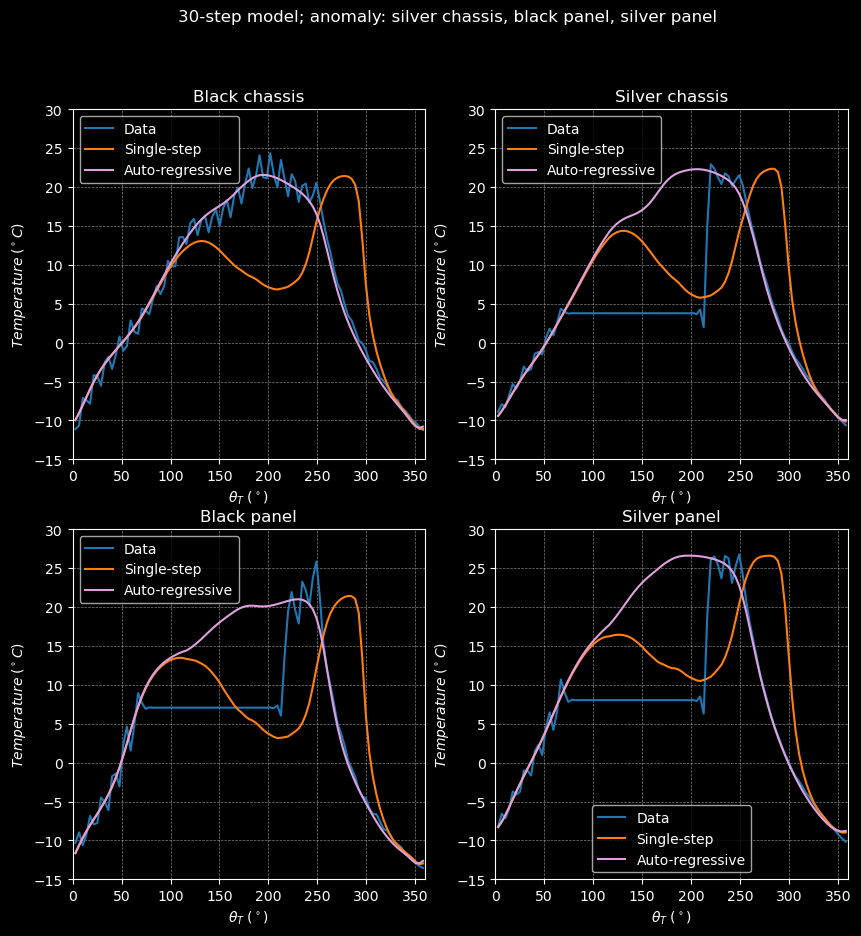

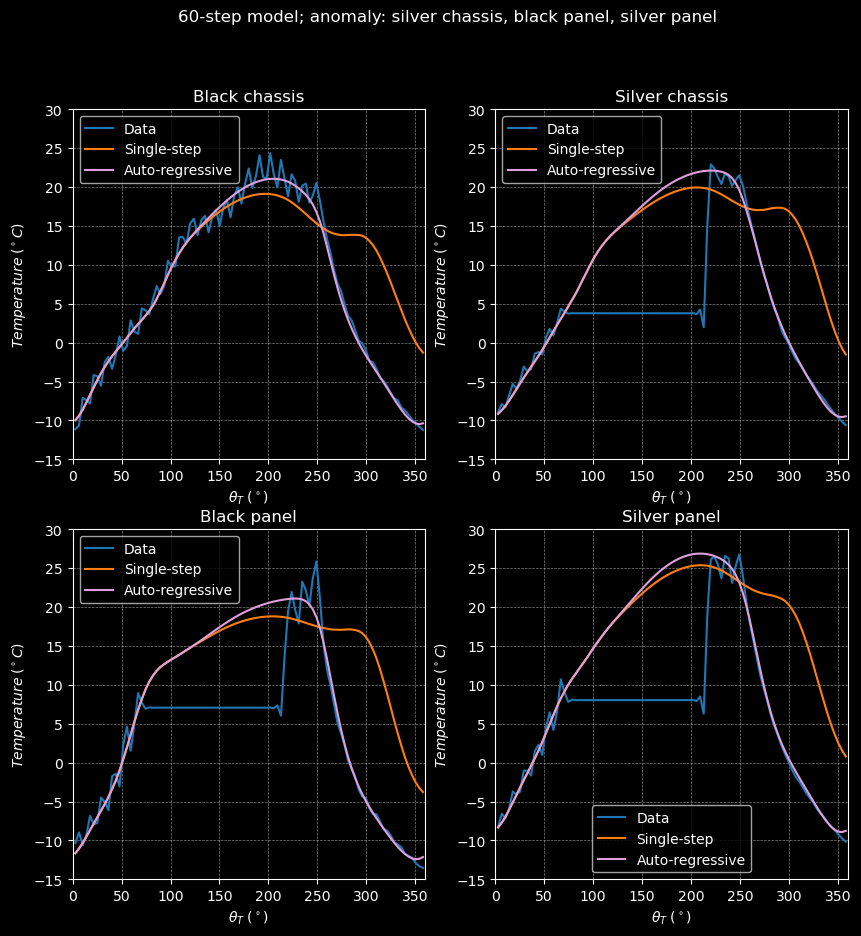

In [ ]:
# Artificial anomaly orbit: silver chassis, black panel, silver panel
three_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True,)
three_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True,)

three_anomaly_30_window_df, three_anomaly_30_x, three_anomaly_30_y = section_data(three_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
three_anomaly_60_window_df, three_anomaly_60_x, three_anomaly_60_y = section_data(three_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

three_anomaly_30_y_single_pred, three_anomaly_30_y_auto_pred = test_model(model_30, three_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
three_anomaly_60_y_single_pred, three_60_y_auto_pred = test_model(model_60, three_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    three_anomaly_30_window_df["theta_T"],
    three_anomaly_30_y * (max_temp - min_temp) + min_temp,
    three_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
    three_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; anomaly: silver chassis, black panel, silver panel",
)

plot_model(
    three_anomaly_60_window_df["theta_T"],
    three_anomaly_60_y * (max_temp - min_temp) + min_temp,
    three_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    three_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; anomaly: silver chassis, black panel, silver panel",
)

Predicting [========================================] 97/97 [100%] in 5.8s (16.74/s)                                    
Predicting [========================================] 97/97 [100%] in 6.9s (14.05/s)                                    


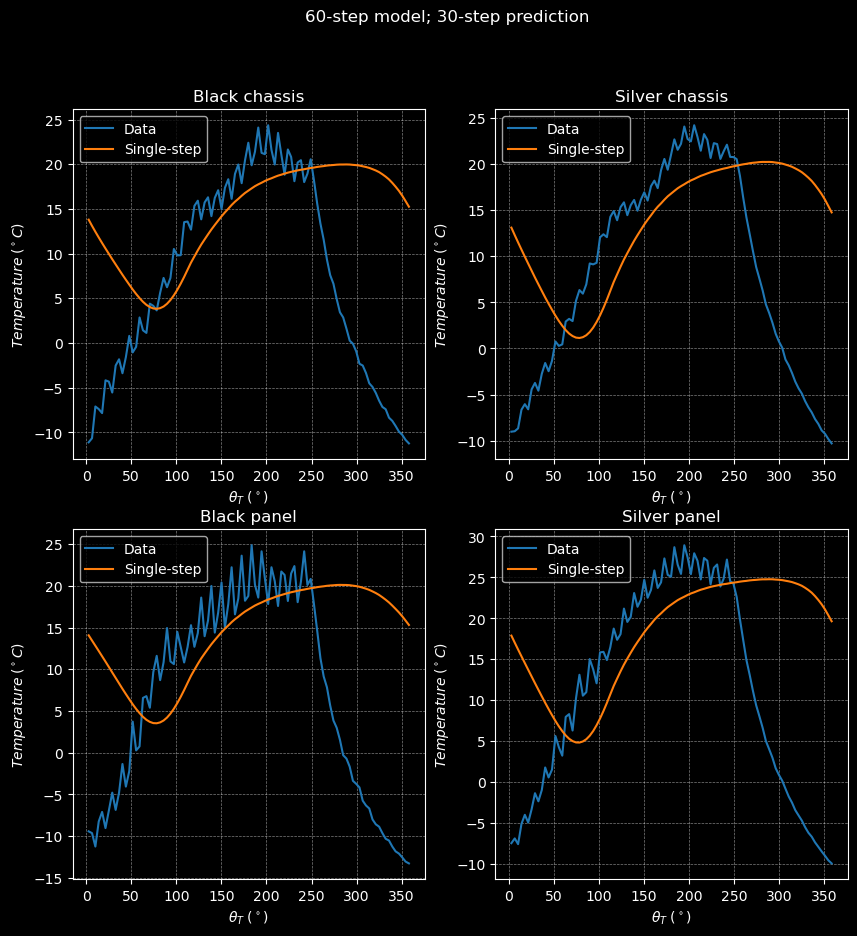

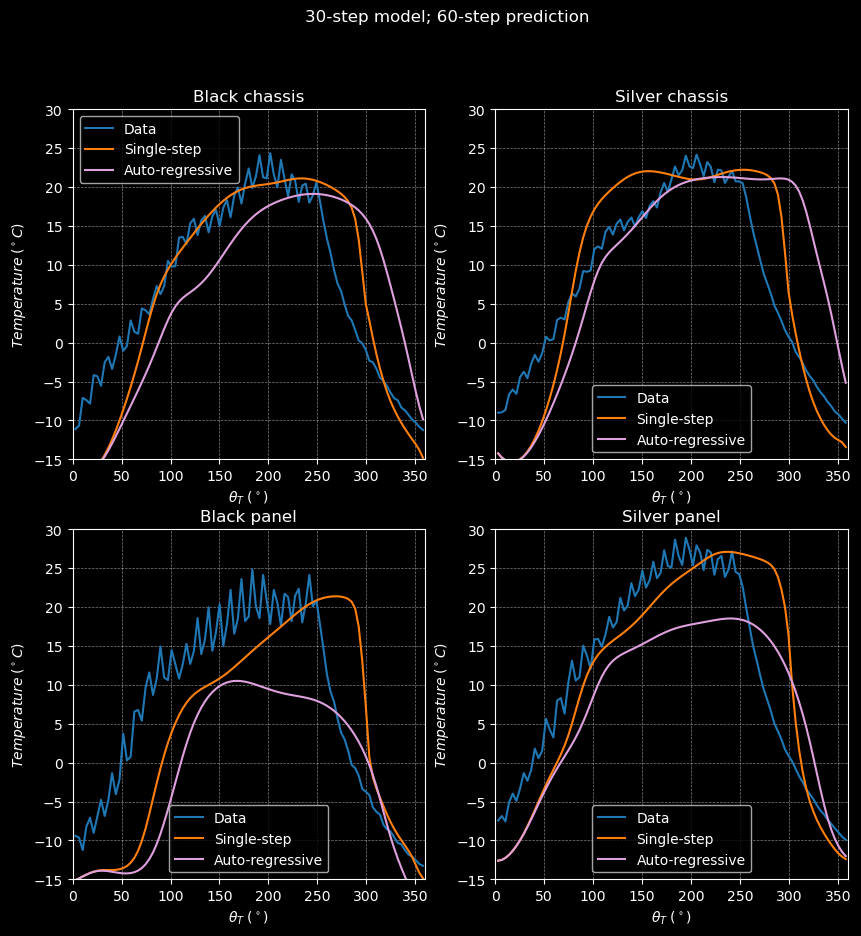

In [ ]:
# Orbit without anomaly:
cross_30_y_single_pred, cross_30_y_auto_pred = test_model(model_60, base_30_x, single_step_pred=True, auto_regressive_pred=True)
cross_60_y_single_pred, cross_60_y_auto_pred = test_model(model_30, base_60_x, single_step_pred=True, auto_regressive_pred=True)

plot_model(
    base_30_window_df["theta_T"],
    base_30_y * (max_temp - min_temp) + min_temp,
    cross_30_y_single_pred * (max_temp - min_temp) + min_temp,
    # cross_30_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-step model; 30-step prediction",
    limit_axis=False,
)

plot_model(
    base_60_window_df["theta_T"],
    base_60_y * (max_temp - min_temp) + min_temp,
    cross_60_y_single_pred * (max_temp - min_temp) + min_temp,
    cross_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; 60-step prediction",
)

Predicting [========================================] 97/97 [100%] in 6.6s (14.59/s)                                    


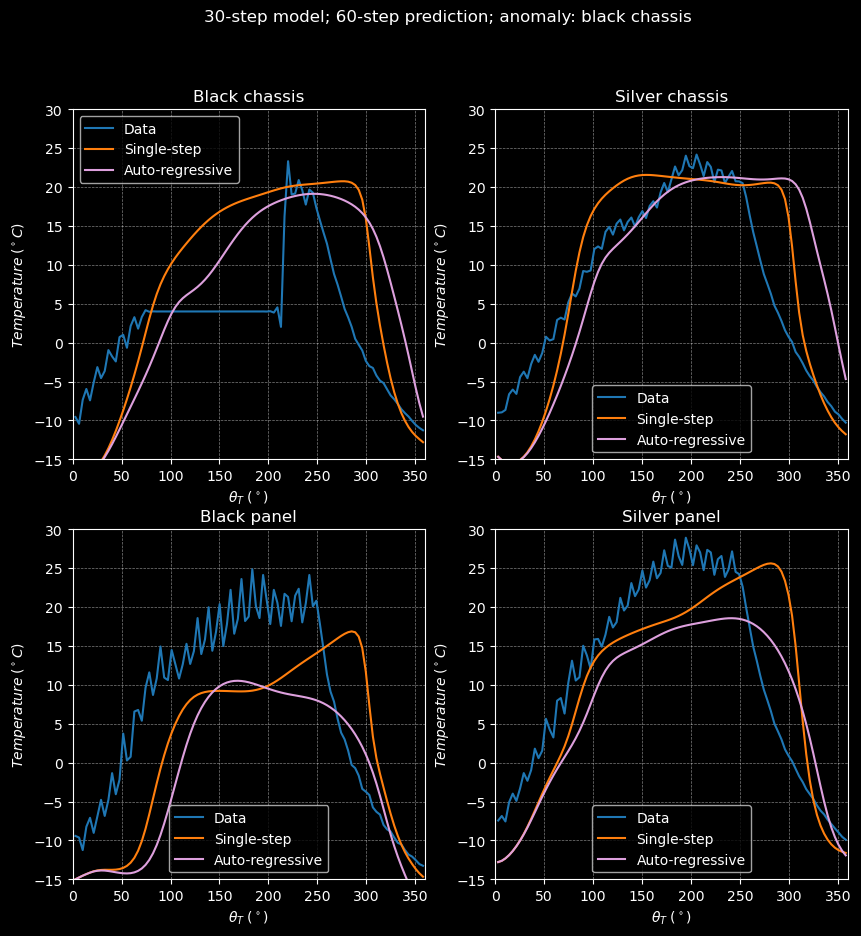

In [ ]:
# Cross model artificial anomaly orbit: black chassis
# one_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
one_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True,)

# one_anomaly_30_window_df, one_anomaly_30_x, one_anomaly_30_y = section_data(one_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
one_anomaly_60_window_df, one_anomaly_60_x, one_anomaly_60_y = section_data(one_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

# one_anomaly_30_y_single_pred, one_anomaly_30_y_auto_pred = test_model(model_30, one_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
cross_one_anomaly_60_y_single_pred, cross_one_60_y_auto_pred = test_model(model_30, one_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

# plot_model(
#     one_anomaly_30_window_df["theta_T"],
#     one_anomaly_30_y * (max_temp - min_temp) + min_temp,
#     one_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
#     one_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
#     plt_title="30-step model; anomaly: black chassis",
# )

plot_model(
    one_anomaly_60_window_df["theta_T"],
    one_anomaly_60_y * (max_temp - min_temp) + min_temp,
    cross_one_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    cross_one_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; 60-step prediction; anomaly: black chassis",
)

Predicting [========================================] 97/97 [100%] in 6.6s (14.67/s)                                    


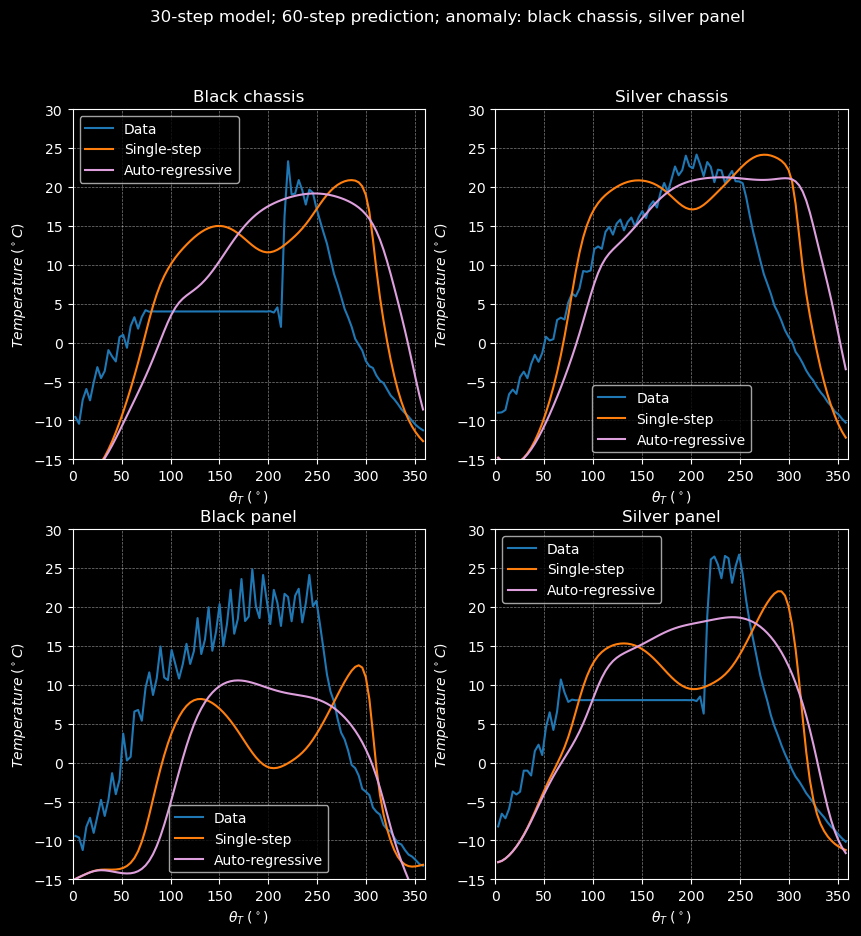

In [ ]:
# Cross model artificial anomaly orbit: black chassis, silver panel
# two_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
two_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_panel=True)

# two_anomaly_30_window_df, two_anomaly_30_x, two_anomaly_30_y = section_data(two_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
two_anomaly_60_window_df, two_anomaly_60_x, two_anomaly_60_y = section_data(two_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

# two_anomaly_30_y_single_pred, two_anomaly_30_y_auto_pred = test_model(model_30, two_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
cross_two_anomaly_60_y_single_pred, cross_two_60_y_auto_pred = test_model(model_30, two_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

# plot_model(
#     two_anomaly_30_window_df["theta_T"],
#     two_anomaly_30_y * (max_temp - min_temp) + min_temp,
#     two_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
#     two_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
#     plt_title="30-step model; anomaly: black chassis",
# )

plot_model(
    two_anomaly_60_window_df["theta_T"],
    two_anomaly_60_y * (max_temp - min_temp) + min_temp,
    cross_two_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    cross_two_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; 60-step prediction; anomaly: black chassis, silver panel",
)

Predicting [========================================] 97/97 [100%] in 6.4s (15.06/s)                                    


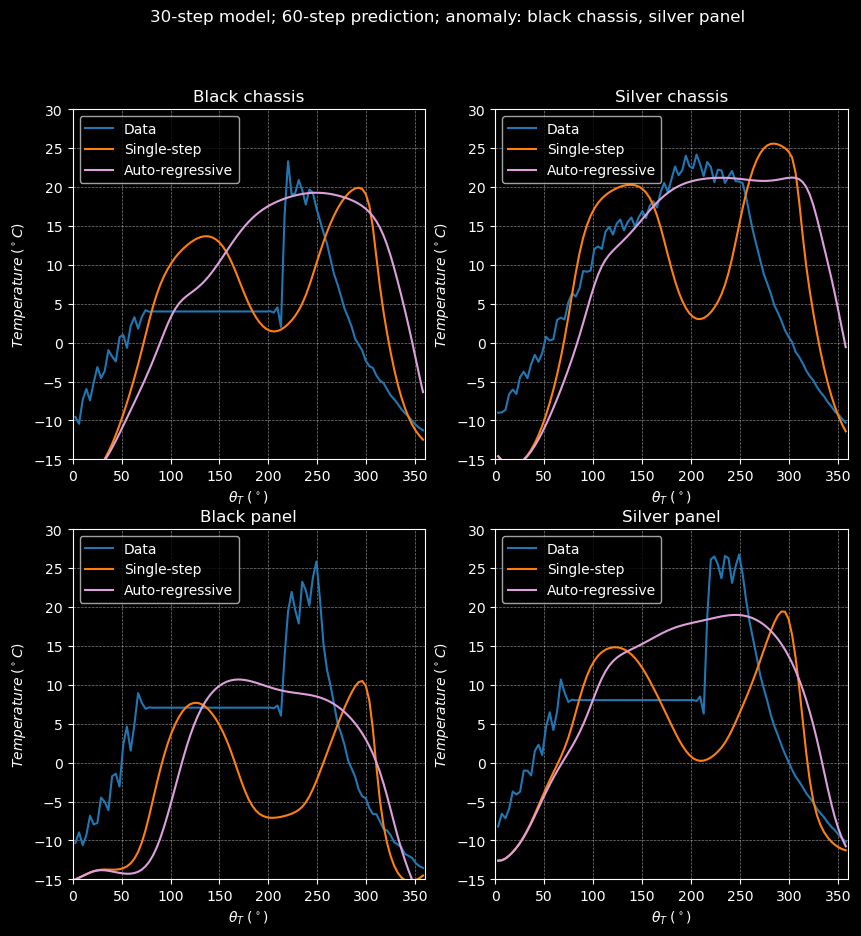

In [ ]:
# Cross model artificial anomaly orbit: black chassis, black panel, silver panel
# three_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
three_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True)

# three_anomaly_30_window_df, three_anomaly_30_x, three_anomaly_30_y = section_data(three_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
three_anomaly_60_window_df, three_anomaly_60_x, three_anomaly_60_y = section_data(three_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

# three_anomaly_30_y_single_pred, three_anomaly_30_y_auto_pred = test_model(model_30, three_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
cross_three_anomaly_60_y_single_pred, cross_three_60_y_auto_pred = test_model(model_30, three_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

# plot_model(
#     three_anomaly_30_window_df["theta_T"],
#     three_anomaly_30_y * (max_temp - min_temp) + min_temp,
#     three_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
#     three_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
#     plt_title="30-step model; anomaly: black chassis",
# )

plot_model(
    three_anomaly_60_window_df["theta_T"],
    three_anomaly_60_y * (max_temp - min_temp) + min_temp,
    cross_three_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    cross_three_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; 60-step prediction; anomaly: black chassis, silver panel",
)

In [ ]:
# Cross model artificial anomaly orbit: all anomalies
# all_anomaly_30_df = create_artificial_anomaly(window_size=30, anomaly_black_chassis=True,)
all_anomaly_60_df = create_artificial_anomaly(window_size=60, anomaly_black_chassis=True, anomaly_silver_chassis=True, anomaly_black_panel=True, anomaly_silver_panel=True)

# all_anomaly_30_window_df, all_anomaly_30_x, all_anomaly_30_y = section_data(all_anomaly_30_df, window_size=30, return_numpy=True, check_continuity=False)
all_anomaly_60_window_df, all_anomaly_60_x, all_anomaly_60_y = section_data(all_anomaly_60_df, window_size=60, return_numpy=True, check_continuity=False)

# all_anomaly_30_y_single_pred, all_anomaly_30_y_auto_pred = test_model(model_30, all_anomaly_30_x, single_step_pred=True, auto_regressive_pred=True)
cross_all_anomaly_60_y_single_pred, cross_all_60_y_auto_pred = test_model(model_30, all_anomaly_60_x, single_step_pred=True, auto_regressive_pred=True)

# plot_model(
#     all_anomaly_30_window_df["theta_T"],
#     all_anomaly_30_y * (max_temp - min_temp) + min_temp,
#     all_anomaly_30_y_single_pred * (max_temp - min_temp) + min_temp,
#     all_anomaly_30_y_auto_pred * (max_temp - min_temp) + min_temp,
#     plt_title="30-step model; anomaly: black chassis",
# )

plot_model(
    all_anomaly_60_window_df["theta_T"],
    all_anomaly_60_y * (max_temp - min_temp) + min_temp,
    cross_all_anomaly_60_y_single_pred * (max_temp - min_temp) + min_temp,
    cross_all_60_y_auto_pred * (max_temp - min_temp) + min_temp,
    plt_title="30-step model; 60-step prediction; anomaly: all anomalies",
)

Predicting [========================================] 97/97 [100%] in 6.8s (14.36/s)                                    
